In [1]:
import yaml
from joblib import load
import pandas as pd
from backend.utils.data_preprocessor import DataPreprocessor

with open('../config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

interval: str = "1min"
lookback_period: int = config['preprocess']['lookback_period']
trend_length: int = config['preprocess']['trend_length']
target_column: str = config['preprocess']['target']
testing_file_path: str = f"../data/twelvedata/feature time series (1min)/NVDA_feature_time_series.csv"
testing_df: pd.DataFrame = pd.read_csv(testing_file_path)


In [2]:
testing_preprocessor = DataPreprocessor(testing_df, lookback_period, target_column, trend_length)

X_test: [[[float]]] = testing_preprocessor.feature_data_batched
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
y_test: [float] = testing_preprocessor.label_data


In [3]:
scaler = load('scaler.save')
X_test_scaled_reshaped = scaler.transform(X_test_reshaped)
X_test_scaled = X_test_scaled_reshaped.reshape(X_test.shape)


In [4]:
print("Testing Dataset shape:", testing_df.shape)
print("Testing Dataset as time series batches:",X_test.shape, y_test.shape)
# %run ../tests/trend_provider_validator.py

Testing Dataset shape: (4970, 20)
Testing Dataset as time series batches: (4966, 3, 20) (4966,)


In [5]:
from keras.models import load_model
from backend.utils.model_evaluator import ModelEvaluator

model_path: str = "../models/saved models/trained_StockTrendLSTM_model.keras"
model = load_model(model_path)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
y_pred_prob: [float] = model.predict(X_test_scaled).flatten()
y_pred: [int] = (y_pred_prob > 0.5).astype(int)

model_evaluator = ModelEvaluator(test_loss, y_test, y_pred)
metrics_df = model_evaluator.evaluation_metrics
metrics_df





156/156 [==============================] - 2s 3ms/step


,Metric,Score
0,Loss,0.670173
1,Accuracy,0.762586
2,Precision,0.818182
3,Recall,0.647727
4,F1Score,0.723044
5,ROC AUC,0.757840


In [6]:
target_data: pd.DataFrame = testing_preprocessor.target_data[lookback_period:]
feature_data: pd.DataFrame = testing_preprocessor.feature_data[lookback_period:]
label_data: pd.DataFrame = testing_preprocessor.label_data

profits: pd.Series = target_data['close'].shift(-trend_length) - target_data['close']
profitable_trade: pd.Series = (profits > 0).astype(int)
last_close: pd.Series = target_data['close'].shift(8)
next_low: pd.Series = target_data['low'].shift(-1)
next_high: pd.Series = target_data['high'].shift(-1)
next_close: pd.Series = target_data['close'].shift(-1)

results: pd.DataFrame = target_data.assign(prediction=y_pred,
                                           probability=y_pred_prob,
                                           profit=profits,
                                           profitable=profitable_trade,
                                           next_low=next_low,
                                           next_high=next_high,
                                           next_close=next_close,
                                           last_close=last_close)

results: pd.DataFrame = results[['open', 'high', 'low', 'close','last_close', 'next_high', 'next_low', 'next_close', 'sma', 'profitable', 'label', 'prediction', 'probability']]
results.head(50)


,open,high,low,close,last_close,next_high,next_low,next_close,sma,profitable,label,prediction,probability
datetime,,,,,,,,,,,,,
2024-07-17 15:27:00,118.53,118.71,118.45,118.64,NaN,118.90,118.64,118.87,118.4656,1,1,1,0.527393
2024-07-17 15:28:00,118.64,118.90,118.64,118.87,NaN,118.95,118.73,118.93,118.5378,1,1,1,0.522101
2024-07-17 15:29:00,118.86,118.95,118.73,118.93,NaN,119.00,118.80,119.00,118.6167,1,1,1,0.523557
2024-07-17 15:30:00,118.92,119.00,118.80,119.00,NaN,119.10,118.95,119.00,118.6944,0,1,1,0.538152
2024-07-17 15:31:00,118.99,119.10,118.95,119.00,NaN,119.07,118.75,118.82,118.7500,0,1,1,0.537677
2024-07-17 15:32:00,119.00,119.07,118.75,118.82,NaN,118.92,118.70,118.78,118.7878,0,1,1,0.535883
2024-07-17 15:33:00,118.83,118.92,118.70,118.78,NaN,118.82,118.64,118.66,118.8067,0,0,1,0.527204
2024-07-17 15:34:00,118.79,118.82,118.64,118.66,NaN,118.67,118.47,118.54,118.8044,0,0,1,0.508402
2024-07-17 15:35:00,118.67,118.67,118.47,118.54,118.64,118.64,118.42,118.63,118.8044,1,0,0,0.485665


In [13]:
high_over_close: bool = (results['next_low'] < results['last_close'])
probability: bool = (results['probability'] > 0.51)

sma_opportunities: pd.DataFrame = results[probability]
print(sma_opportunities['label'].value_counts())
print(sma_opportunities['profitable'].value_counts(normalize=True))

sma_opportunities

label
1    1059
0     160
Name: count, dtype: int64
profitable
0    0.519278
1    0.480722
Name: proportion, dtype: float64


,open,high,low,close,last_close,next_high,next_low,next_close,sma,profitable,label,prediction,probability
datetime,,,,,,,,,,,,,
2024-07-17 15:27:00,118.53,118.71,118.45,118.64,NaN,118.90,118.64,118.87,118.4656,1,1,1,0.527393
2024-07-17 15:28:00,118.64,118.90,118.64,118.87,NaN,118.95,118.73,118.93,118.5378,1,1,1,0.522101
2024-07-17 15:29:00,118.86,118.95,118.73,118.93,NaN,119.00,118.80,119.00,118.6167,1,1,1,0.523557
2024-07-17 15:30:00,118.92,119.00,118.80,119.00,NaN,119.10,118.95,119.00,118.6944,0,1,1,0.538152
2024-07-17 15:31:00,118.99,119.10,118.95,119.00,NaN,119.07,118.75,118.82,118.7500,0,1,1,0.537677
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05 12:25:00,102.67,102.80,102.54,102.70,101.44,103.00,102.45,102.99,101.9778,1,1,1,0.510862
2024-08-05 12:26:00,102.71,103.00,102.45,102.99,101.71,103.10,102.77,102.92,102.1500,0,1,1,0.511414
2024-08-05 12:27:00,102.97,103.10,102.77,102.92,101.93,103.40,102.88,103.30,102.2844,1,1,1,0.516832


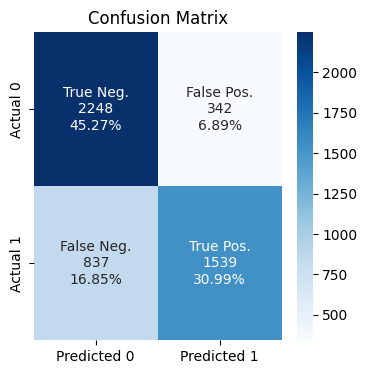

In [8]:
from backend.utils.visualizing_service import plot_confusion_matrix
plot_confusion_matrix(y_test, y_pred)

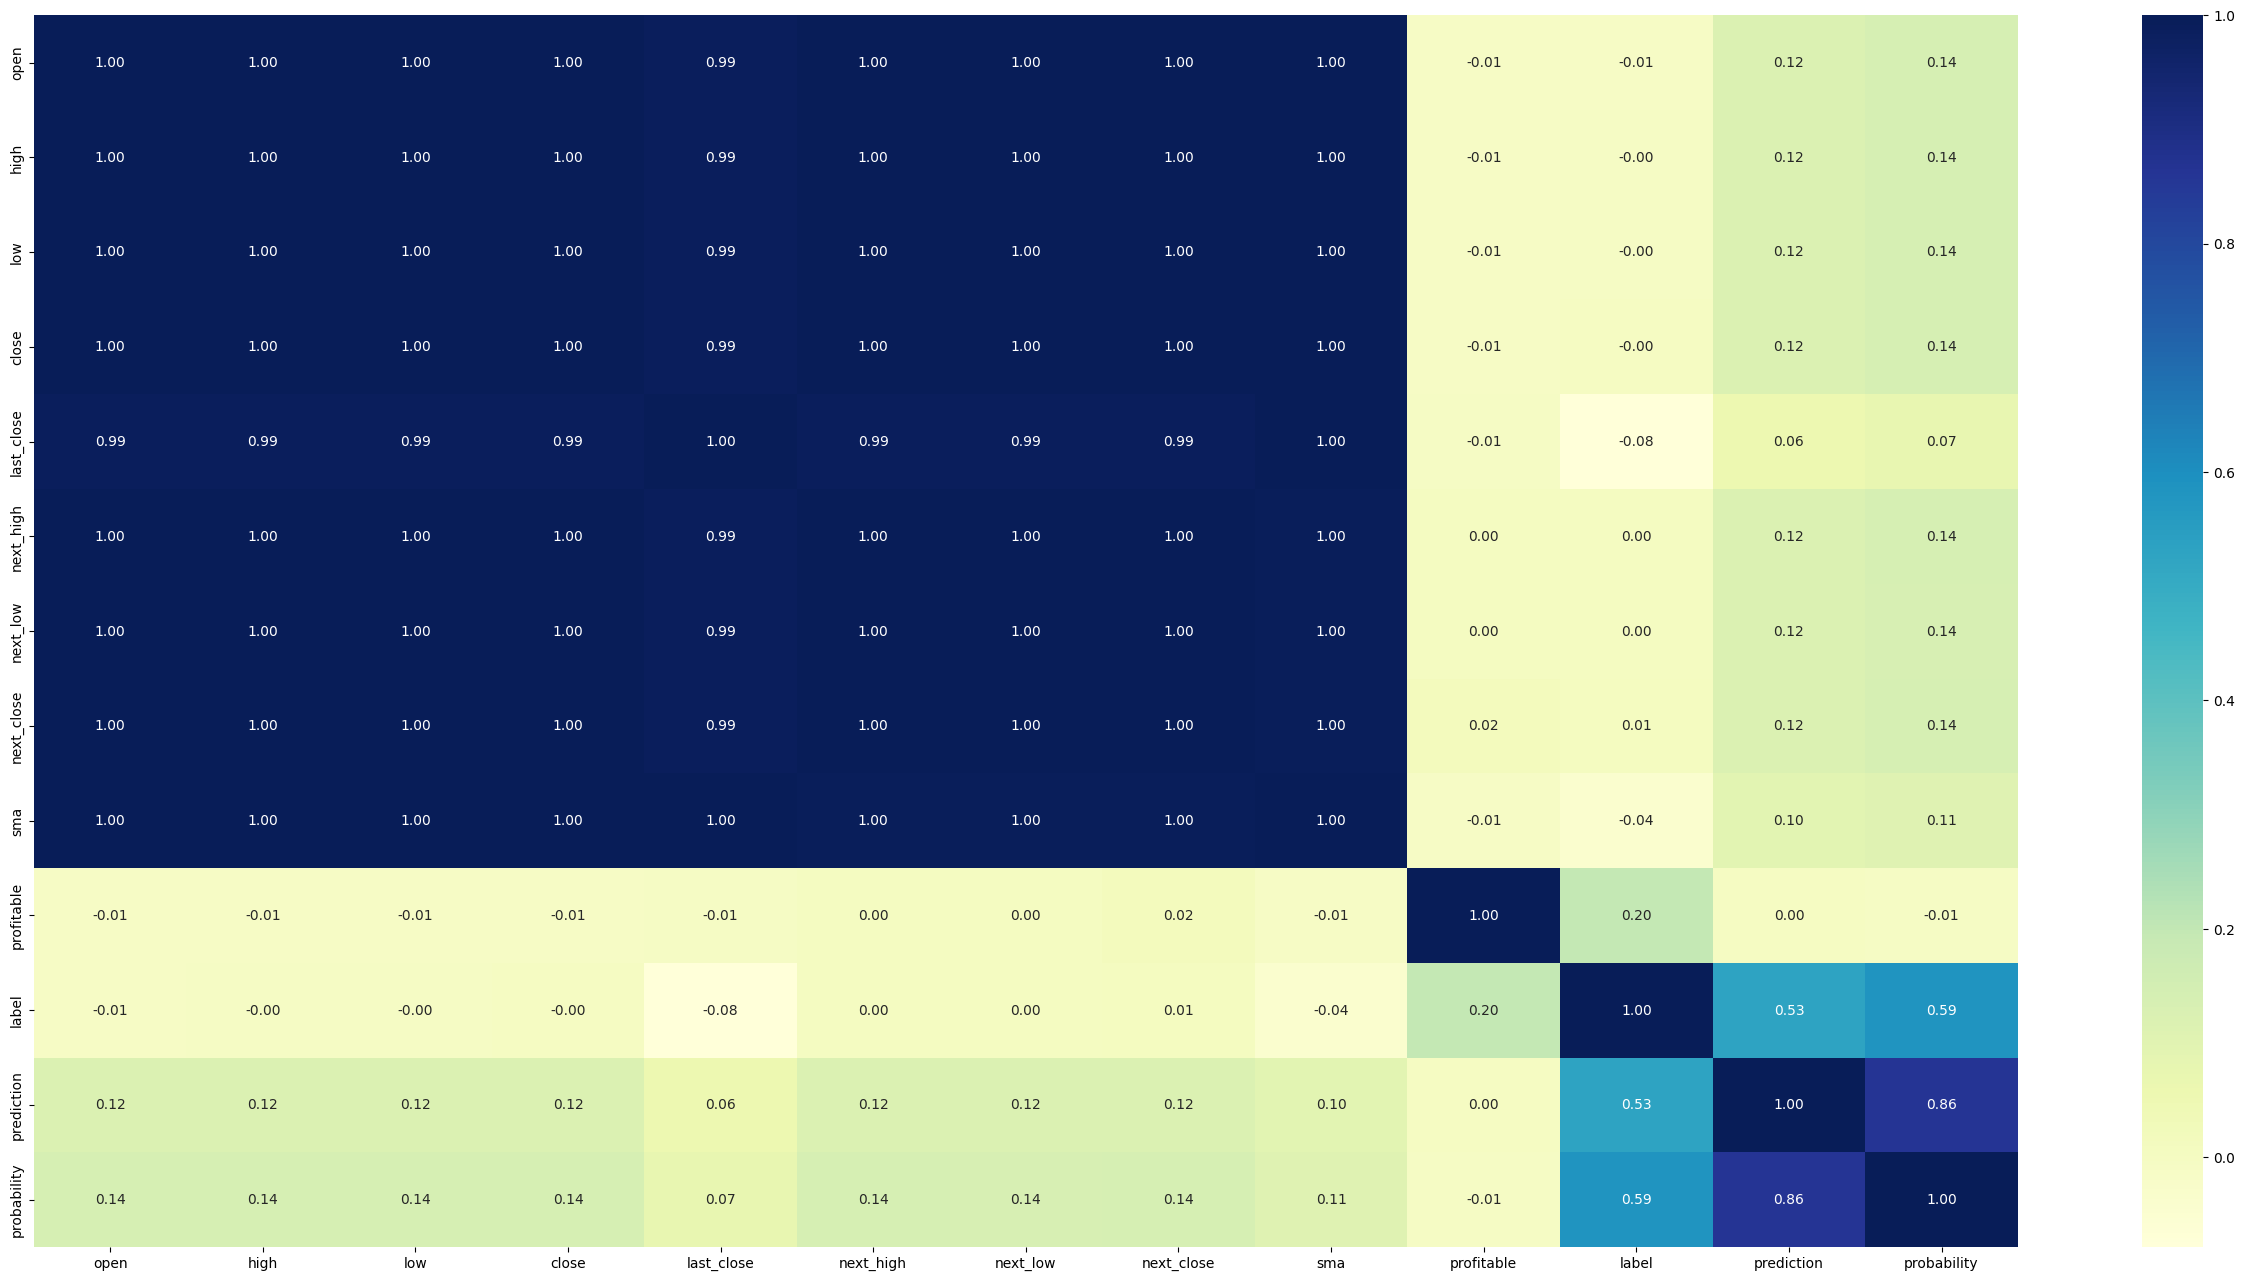

In [9]:
from backend.utils.visualizing_service import plot_correlation_heatmap
plot_correlation_heatmap(results)
